In [1]:
# Standard Libaries
import os
import datetime
from IPython.display import Audio
from tqdm.notebook import trange, tqdm

# Statistics / Analsyis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
import scipy
import pandas as pd
import cv2
import librosa
from scipy.signal import find_peaks
import sklearn
from scipy.ndimage import convolve
import scipy

import seaborn as sns
sns.set()

C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ANNOTATIONS_PATH = R'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations2'

annotation_files = [os.path.join(ANNOTATIONS_PATH, i) for i in os.listdir(ANNOTATIONS_PATH)]

annotation_dataframes = [pd.read_excel(i, index_col=0) for i in annotation_files]


In [3]:
annotations = pd.concat(annotation_dataframes)
annotations['Date'] = annotations['Date'].astype(str)


annotations.insert(loc=1, column='DateTime', value=
    pd.to_datetime(dict(year = annotations['Date'].str[:4], 
                        month = annotations['Date'].str[4:6], 
                        day = annotations['Date'].str[6:],
                        hour = annotations['Hour'],
                        minute = annotations['Second']//60,
                        second = annotations['Second']%60) ))

annotations = annotations.drop('Hour', axis=1)
annotations = annotations.drop('Second', axis=1)
annotations = annotations.drop('Date', axis=1)

annotations = annotations.set_index('DateTime')

In [4]:
annotations

,Label,Confidence,Duration,Mean Frequency,L50 Power,L90 Power,L99 Power,63 Hz Third Band
DateTime,,,,,,,,
2016-01-01 07:35:00,Humpback,0.875,50,546.562902,71.420296,77.278186,98.078500,75.647096
2016-01-01 07:36:40,Humpback,0.873,50,546.979066,71.126404,76.497353,85.251711,76.029973
2016-01-01 07:37:30,Humpback,0.896,50,546.364228,71.220562,76.705585,88.783516,76.456729
2016-01-01 07:45:50,Humpback,0.905,50,546.757257,71.239647,76.684199,85.817909,77.912214
2016-01-01 07:46:40,Humpback,0.970,50,546.384088,71.270477,76.728761,87.893139,76.724417
...,...,...,...,...,...,...,...,...
2022-12-30 23:52:30,Humpback,1.000,50,543.103348,65.785610,71.907867,89.726008,70.077458
2022-12-30 23:53:20,Humpback,1.000,50,542.803581,65.820995,72.075391,89.037630,70.407509
2022-12-30 23:54:10,Humpback,1.000,50,543.968369,65.837009,71.682775,85.382987,71.224213


In [6]:
BLUE_A = {'2016': (annotations[annotations['Label'] == 'BLUE_A']).loc['2016'],
          '2018': (annotations[annotations['Label'] == 'BLUE_A']).loc['2018'],
          '2020': (annotations[annotations['Label'] == 'BLUE_A']).loc['2020'],
          '2022': (annotations[annotations['Label'] == 'BLUE_A']).loc['2022']}

BLUE_B = {'2016': (annotations[annotations['Label'] == 'BLUE_B']).loc['2016'],
          '2018': (annotations[annotations['Label'] == 'BLUE_B']).loc['2018'],
          '2020': (annotations[annotations['Label'] == 'BLUE_B']).loc['2020'],
          '2022': (annotations[annotations['Label'] == 'BLUE_B']).loc['2022']}

HUMPBACK = {'2016': (annotations[annotations['Label'] == 'Humpback']).loc['2016'],
            '2018': (annotations[annotations['Label'] == 'Humpback']).loc['2018'],
            '2020': (annotations[annotations['Label'] == 'Humpback']).loc['2020'],
            '2022': (annotations[annotations['Label'] == 'Humpback']).loc['2022']}

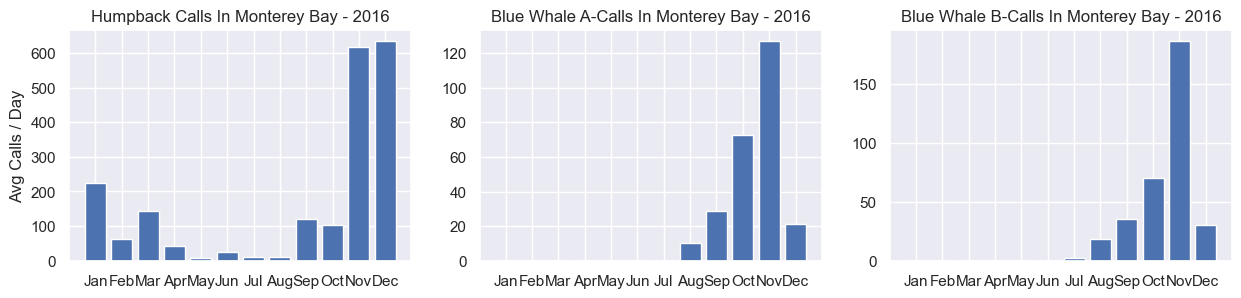

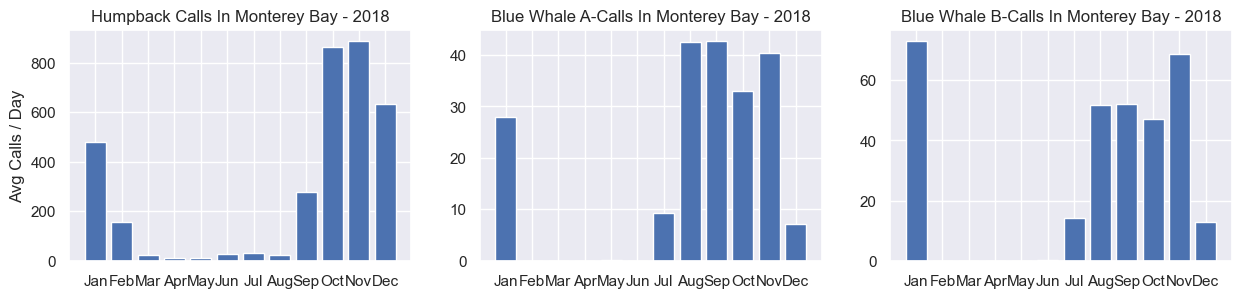

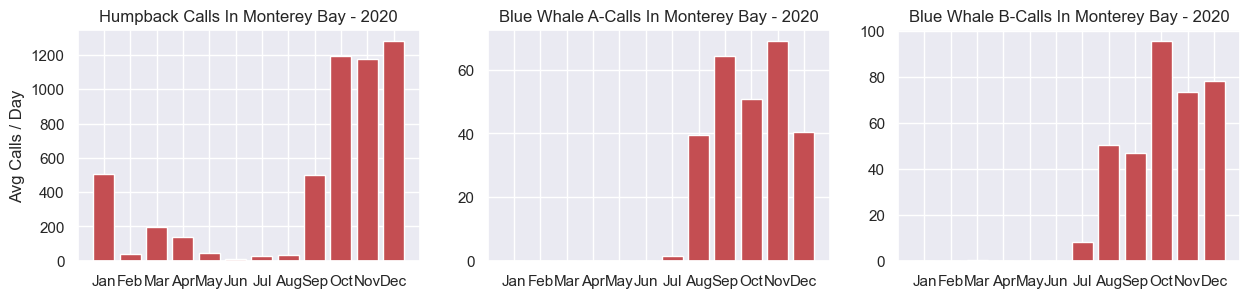

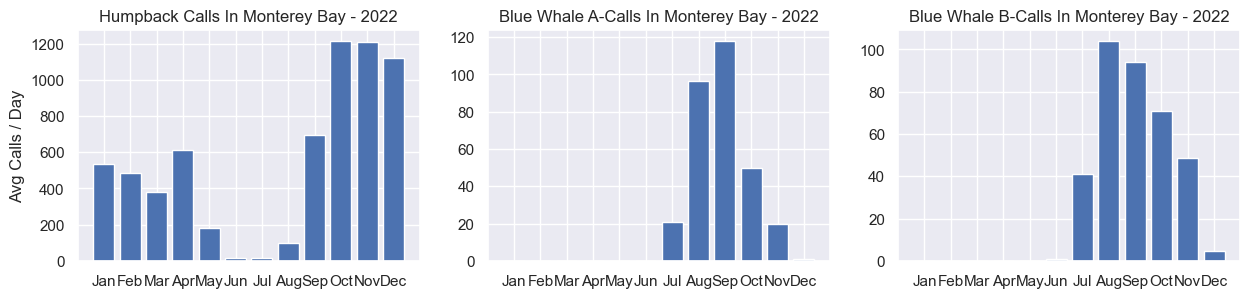

In [7]:


##############################################
fig, axs = plt.subplots(1, 3, figsize=(15,3))

year = '2016'
color = 'b'
axs[0].set_title("Humpback Calls In Monterey Bay - {}".format(year))
axs[0].set_ylabel("Avg Calls / Day")
axs[0].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[1].set_title("Blue Whale A-Calls In Monterey Bay - {}".format(year))
axs[1].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_A[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[2].set_title("Blue Whale B-Calls In Monterey Bay - {}".format(year))
axs[2].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_B[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)
plt.show()

##############################################
fig, axs = plt.subplots(1, 3, figsize=(15,3))

year = '2018'
color = 'b'
axs[0].set_title("Humpback Calls In Monterey Bay - {}".format(year))
axs[0].set_ylabel("Avg Calls / Day")
axs[0].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[1].set_title("Blue Whale A-Calls In Monterey Bay - {}".format(year))
axs[1].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_A[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[2].set_title("Blue Whale B-Calls In Monterey Bay - {}".format(year))
axs[2].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_B[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)
plt.show()

##############################################
fig, axs = plt.subplots(1, 3, figsize=(15,3))

year = '2020'
color = 'r'
axs[0].set_title("Humpback Calls In Monterey Bay - {}".format(year))
axs[0].set_ylabel("Avg Calls / Day")
axs[0].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[1].set_title("Blue Whale A-Calls In Monterey Bay - {}".format(year))
axs[1].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_A[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[2].set_title("Blue Whale B-Calls In Monterey Bay - {}".format(year))
axs[2].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_B[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)
plt.show()

##############################################
fig, axs = plt.subplots(1, 3, figsize=(15,3))

year = '2022'
color = 'b'
axs[0].set_title("Humpback Calls In Monterey Bay - {}".format(year))
axs[0].set_ylabel("Avg Calls / Day")
axs[0].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[1].set_title("Blue Whale A-Calls In Monterey Bay - {}".format(year))
axs[1].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_A[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)

axs[2].set_title("Blue Whale B-Calls In Monterey Bay - {}".format(year))
axs[2].bar(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
        [list(BLUE_B[year].index.month).count(i) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
         for i in range(1, 13)], color=color)
plt.show()






In [8]:
print(len(BLUE_A['2016']) / len(set(list(annotations.loc['2016'].index.strftime('%D')))))
print(len(BLUE_A['2018']) / len(set(list(annotations.loc['2018'].index.strftime('%D')))))
print(len(BLUE_A['2020']) / len(set(list(annotations.loc['2020'].index.strftime('%D')))))
print(len(BLUE_A['2022']) / len(set(list(annotations.loc['2022'].index.strftime('%D')))))

23.130434782608695
17.76551724137931
22.72222222222222
25.473684210526315


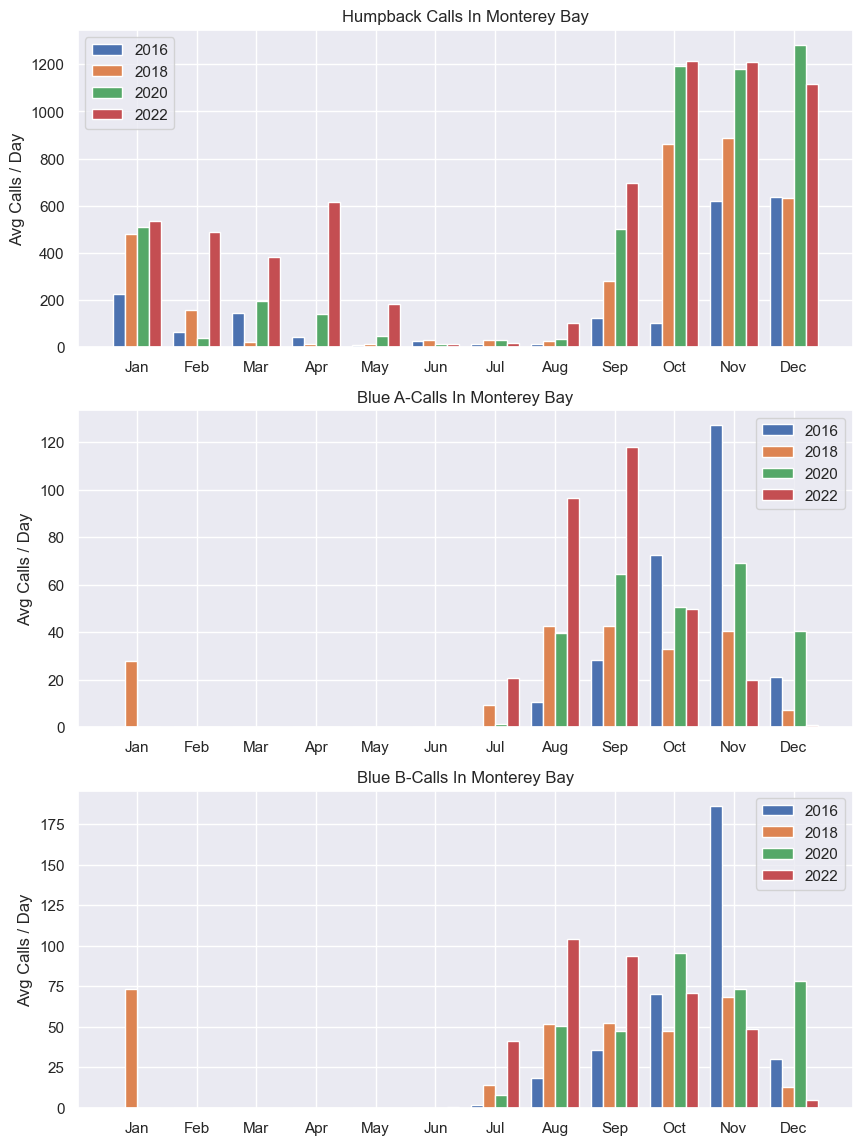

In [9]:


############################################################################################
fig, axs = plt.subplots(3, 1, figsize=(10,14))



axs[0].set_title("Humpback Calls In Monterey Bay")
axs[0].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0.2
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['red', 'green', 'blue', 'orange'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[0].bar(X_axis+w, 
            [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], width, label = year)

axs[0].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].legend()

###########################################################################################

axs[1].set_title("Blue A-Calls In Monterey Bay")
axs[1].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0.2
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['red', 'green', 'blue', 'orange'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[1].bar(X_axis+w, 
            [(list(BLUE_A[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], width, label = year)

axs[1].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].legend()


###########################################################################################

axs[2].set_title("Blue B-Calls In Monterey Bay")
axs[2].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0.2
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['red', 'green', 'blue', 'orange'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[2].bar(X_axis+w, 
            [(list(BLUE_B[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], width, label = year)

axs[2].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[2].legend()


plt.show()

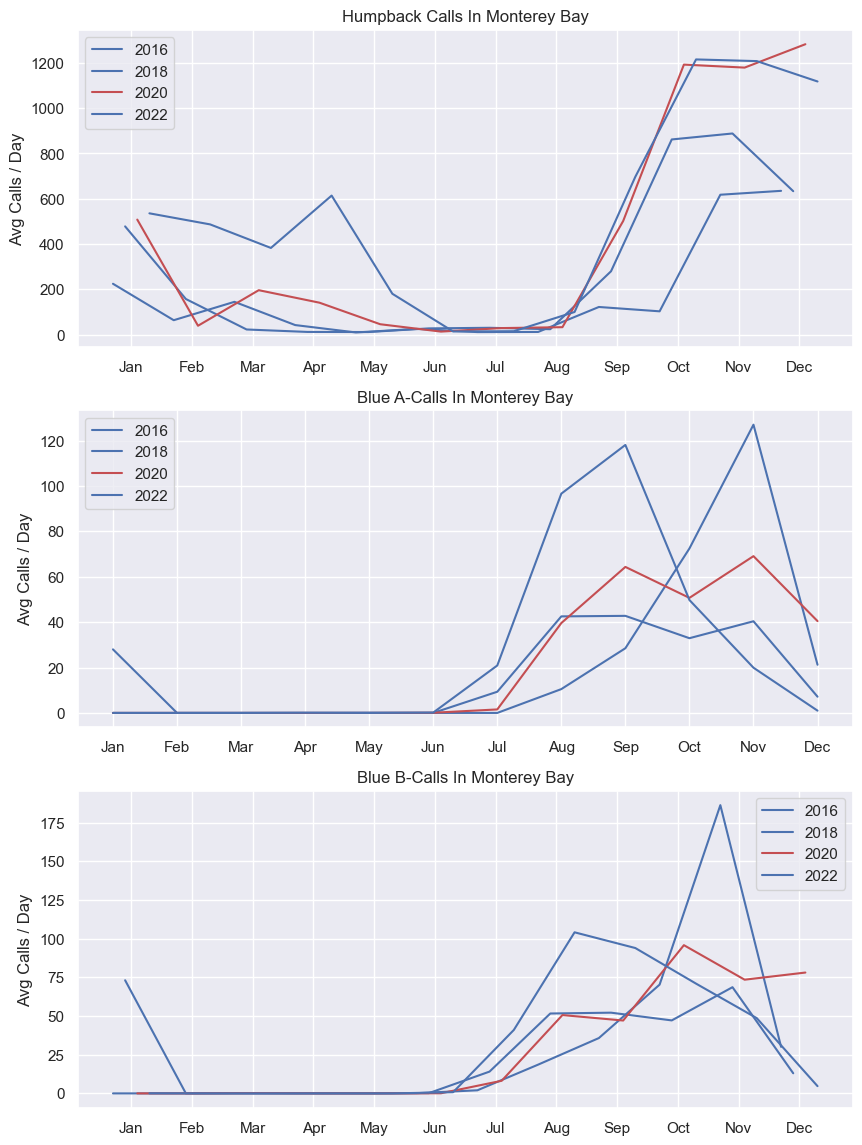

In [10]:


############################################################################################
fig, axs = plt.subplots(3, 1, figsize=(10,14))



axs[0].set_title("Humpback Calls In Monterey Bay")
axs[0].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0.2
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['b', 'b', 'r', 'b'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[0].plot(X_axis+w, 
            [(list(HUMPBACK[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], color=color, label = year)

axs[0].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].legend()

###########################################################################################

axs[1].set_title("Blue A-Calls In Monterey Bay")
axs[1].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['b', 'b', 'r', 'b'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[1].plot(X_axis+w, 
            [(list(BLUE_A[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], color=color, label = year)

axs[1].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].legend()


###########################################################################################

axs[2].set_title("Blue B-Calls In Monterey Bay")
axs[2].set_ylabel("Avg Calls / Day")

X_axis = np.arange(12)
width = 0.2
for year, color, w in zip(['2016', '2018', '2020', '2022'], 
                          ['b', 'b', 'r', 'b'], [(-1.5*width), (-0.5*width), (0.5*width), (1.5*width)]):

    axs[2].plot(X_axis+w, 
            [(list(BLUE_B[year].index.month).count(i)) / len(set(list(annotations.loc[year + '-{}'.format(str(i).rjust(2, '0'))].index.strftime('%D'))))
             for i in range(1, 13)], color=color, label = year)

axs[2].set_xticks(X_axis, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[2].legend()


plt.show()

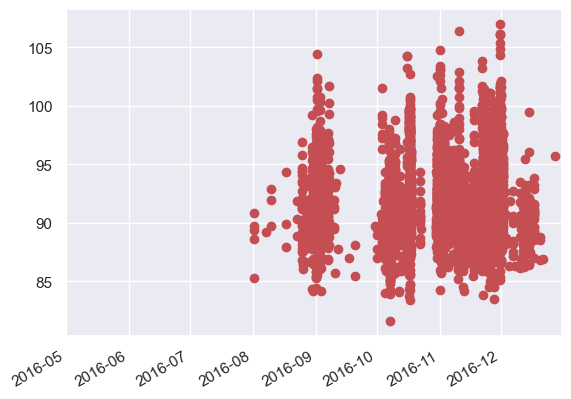

In [11]:
plt.xlim([datetime.date(2016, 5, 1), datetime.date(2016, 12, 31)])
plt.gcf().autofmt_xdate()
plt.scatter(BLUE_A['2016'].index, BLUE_A['2016']['L99 Power'] 
            - BLUE_A['2016']['63 Hz Third Band'] + np.mean(BLUE_A['2016']['63 Hz Third Band']) , color='r')

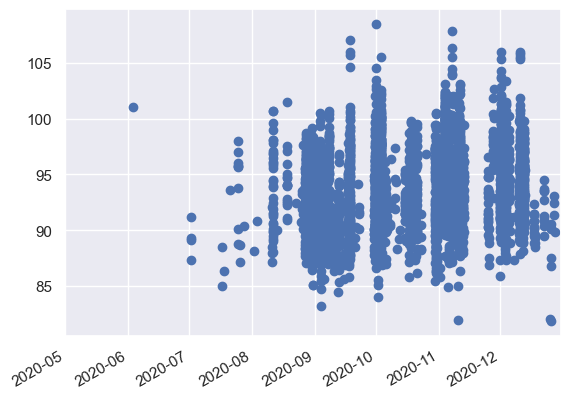

In [12]:
plt.xlim([datetime.date(2020, 5, 1), datetime.date(2020, 12, 31)])
plt.gcf().autofmt_xdate()
plt.scatter(BLUE_A['2020'].index, BLUE_A['2020']['L99 Power'] 
            - BLUE_A['2020']['63 Hz Third Band'] + np.mean(BLUE_A['2020']['63 Hz Third Band']) , color='b')

In [13]:
plt.scatter( BLUE_A['63 Hz Third Band'], BLUE_A['L99 Power'] - BLUE_A['63 Hz Third Band'] + np.mean(BLUE_A['63 Hz Third Band']))


KeyError: '63 Hz Third Band'

<Axes: title={'center': 'Humphback Calls Daily Cycle (2016 Data)'}, xlabel='Hours', ylabel='Frequency'>

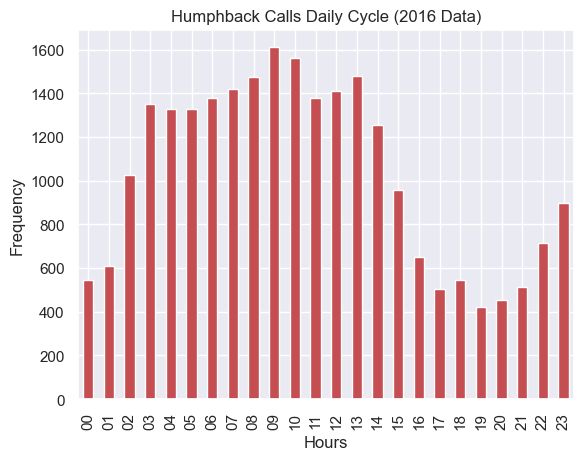

In [29]:
plt.title("Humphback Calls Daily Cycle (2016 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")
HUMPBACK['2016']['Label'].groupby(np.array(HUMPBACK['2016'].index.strftime('%H'))).count().plot(kind="bar", color='r')

<Axes: title={'center': 'Humphback Calls Daily Cycle (2016 Data)'}, xlabel='Hours', ylabel='Frequency'>

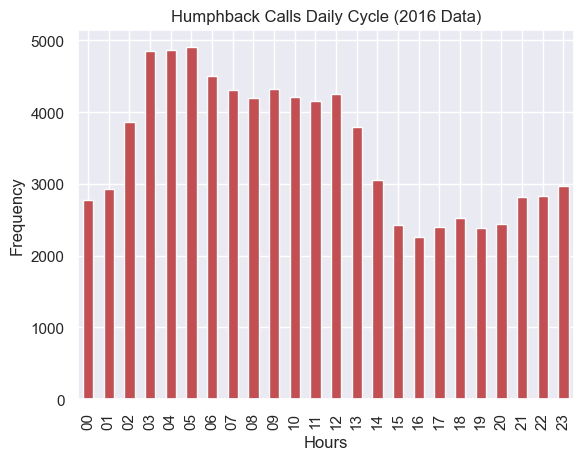

In [30]:
plt.title("Humphback Calls Daily Cycle (2016 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")
HUMPBACK['2022']['Label'].groupby(np.array(HUMPBACK['2022'].index.strftime('%H'))).count().plot(kind="bar", color='r')

In [ ]:
plt.title("Humphback Calls Daily Cycle (2020 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")
HUMPBACK['2020']['Label'].groupby(np.array(HUMPBACK['2020'].index.strftime('%H'))).count().plot(kind="bar")

<Axes: title={'center': 'Blue Whale B-Calls Daily Cycle (2016 Data)'}, xlabel='Hours', ylabel='Frequency'>

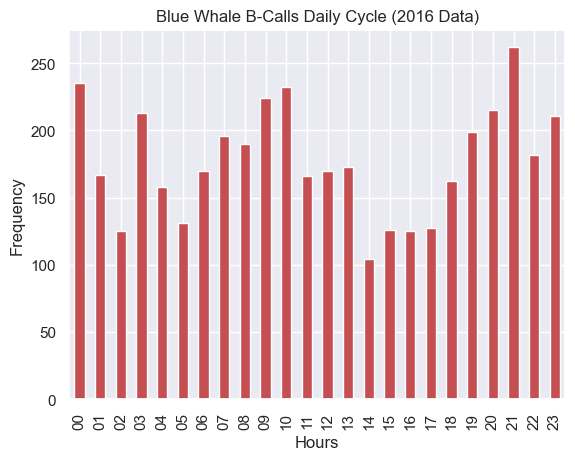

In [15]:
plt.title("Blue Whale B-Calls Daily Cycle (2016 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")

BLUE_B['2016']['Label'].groupby(np.array(BLUE_B['2016'].index.strftime('%H'))).count().plot(kind="bar", color='r')

<Axes: title={'center': 'Blue Whale B-Calls Daily Cycle (2018 Data)'}, xlabel='Hours', ylabel='Frequency'>

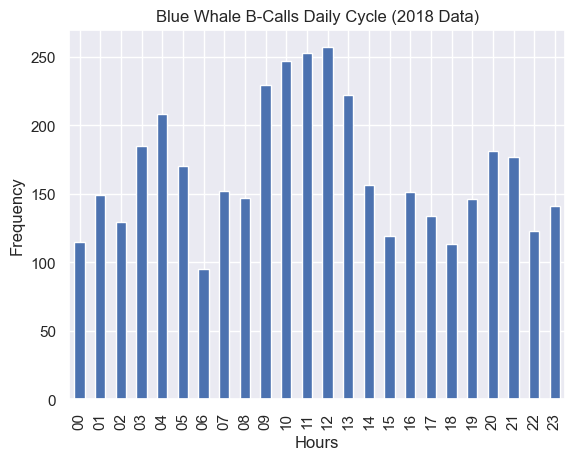

In [21]:
plt.title("Blue Whale B-Calls Daily Cycle (2018 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")

BLUE_B['2018']['Label'].groupby(np.array(BLUE_B['2018'].index.strftime('%H'))).count().plot(kind="bar")

<Axes: title={'center': 'Blue Whale B-Calls Daily Cycle (2020 Data)'}, xlabel='Hours', ylabel='Frequency'>

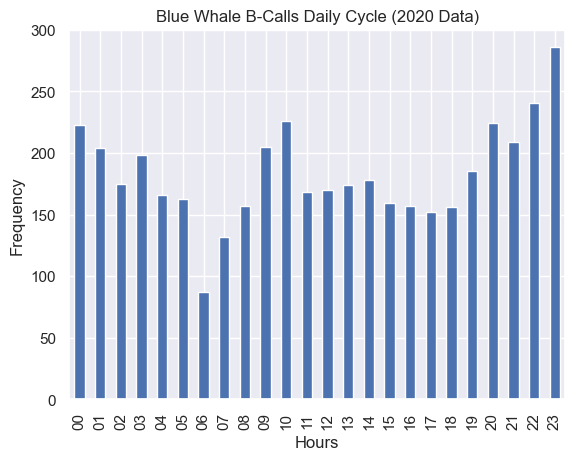

In [28]:
plt.title("Blue Whale B-Calls Daily Cycle (2020 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")

BLUE_B['2020']['Label'].groupby(np.array(BLUE_B['2020'].index.strftime('%H'))).count().plot(kind="bar")

<Axes: title={'center': 'Blue Whale B-Calls Daily Cycle (2022 Data)'}, xlabel='Hours', ylabel='Frequency'>

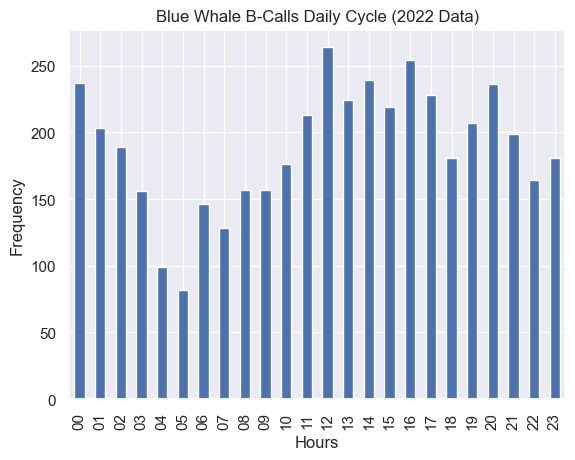

In [25]:
plt.title("Blue Whale B-Calls Daily Cycle (2022 Data)")
plt.xlabel("Hours")
plt.ylabel("Frequency")

BLUE_B['2022']['Label'].groupby(np.array(BLUE_B['2022'].index.strftime('%H'))).count().plot(kind="bar")